# Jonathan Halverson
# Monday, March 7, 2016
# Logistic Regression with StatsModels and Scikit-Learn

### Here we consider blood donation data from a clinic in Vietnam. We are given info about each volunteer. The response is whether or not they donated blood in March of 2007.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

In [7]:
df = pd.read_csv('train_blood.csv')
df.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [8]:
df.corr(method='pearson')

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
Unnamed: 0,1.000000,-0.023217,0.063148,0.063148,0.098370,0.041925
Months since Last Donation,-0.023217,1.000000,-0.159731,-0.159731,0.186899,-0.261234
Number of Donations,0.063148,-0.159731,1.000000,1.000000,0.622116,0.220615
Total Volume Donated (c.c.),0.063148,-0.159731,1.000000,1.000000,0.622116,0.220615
Months since First Donation,0.098370,0.186899,0.622116,0.622116,1.000000,-0.019819
Made Donation in March 2007,0.041925,-0.261234,0.220615,0.220615,-0.019819,1.000000


###Number of donations and total volume are perfectly correlated so we drop one of them as well as first column. We also rename the column headers: 

In [9]:
df.drop(df.columns[[0, 3]], axis=1, inplace=True)
header = {u:v for u, v in zip(df.columns, ['since_last', 'donations', 'since_first', 'march2007'])}
df.rename(columns=header, inplace=True)
df.head()

,since_last,donations,since_first,march2007
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0


In [10]:
df.describe()

,since_last,donations,since_first,march2007
count,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,34.050347,0.239583
std,8.175454,5.740010,24.227672,0.427200
min,0.000000,1.000000,2.000000,0.000000
25%,2.000000,2.000000,16.000000,0.000000
50%,7.000000,4.000000,28.000000,0.000000
75%,14.000000,7.000000,49.250000,0.000000
max,74.000000,50.000000,98.000000,1.000000


### Let's look at various plots of the data:

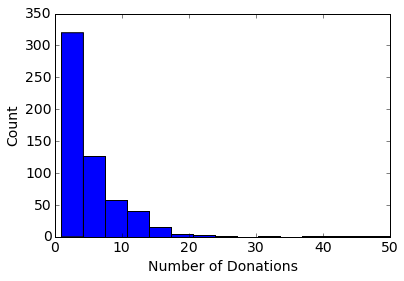

In [11]:
n, bins, patches = plt.hist(df.donations, bins=15)
plt.xlabel('Number of Donations')
plt.ylabel('Count')

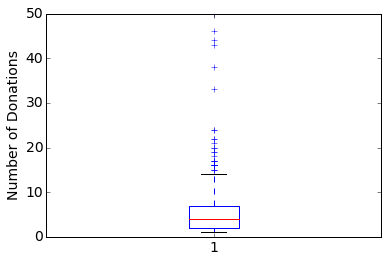

In [12]:
bp = plt.boxplot(df.donations)
plt.ylabel('Number of Donations')

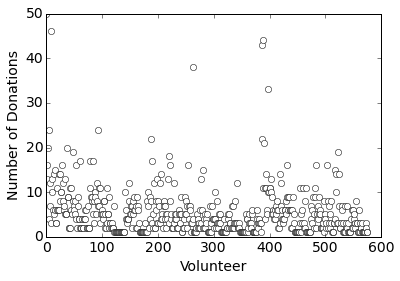

In [13]:
plt.plot(df.donations, 'wo')
plt.xlabel('Volunteer')
plt.ylabel('Number of Donations')

### The two plots above show that donations is right skewed with outliers. If outliers are present in predictor variables, the corresponding observations may be especially influential on the resulting model.

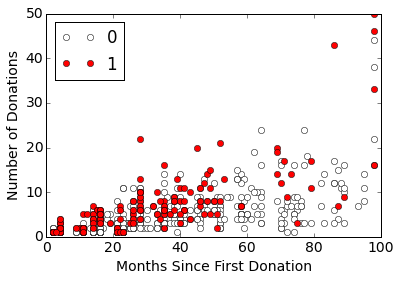

In [14]:
plt.plot(df.since_first[df.march2007 == 0], df.donations[df.march2007 == 0], 'wo', label='0')
plt.plot(df.since_first[df.march2007 == 1], df.donations[df.march2007 == 1], 'ro', label='1')
plt.xlabel('Months Since First Donation')
plt.ylabel('Number of Donations')
plt.legend(loc='upper left')

In [15]:
from scipy.stats import pearsonr
print pearsonr(df.since_first[df.march2007 == 0], df.donations[df.march2007 == 0])
print pearsonr(df.since_first[df.march2007 == 1], df.donations[df.march2007 == 1])

(0.64023843059358876, 6.8411973748325933e-52)
(0.71128731220813646, 1.4353045314777986e-22)


### As expected, there is a positive correlation between when the person started and the total number of donations made. There is no obvious separating line.

### The logistic model is used for binary outcomes or to predict whether an event will happen. It can be used for categorical or numerical data. It can be used to predict the binary outcome or give a probability. The mathematical formula is $\ln\Big(\frac{p_i}{1-p_i}\Big)=\beta_0 + \beta_1 x_{1,i} + \beta_2x_{2,i} + ...$. This can also be written as $p_i = \frac{\exp(\beta_0 + \beta_1 x_{1,i}+ \beta_2 x_{2,i}+...)}{1+\exp(\beta_0 + \beta_1 x_{1,i}+ \beta_2 x_{2,i}+...)}$ 

### Now that we have some sense of the data, let's try to model it using logistic regression. GLMs can be thought of as a two-stage modeling approach. We first model the response variable using a probability distribution, such as the binomial or Poisson distribution. Second, we model the parameter of the distribution using a collection of predictors and a special form of multiple regression.

# Logistic regression with one feature

### For simplicity we begin by assuming the outcome can be predicted based on the number of donations, which we know is a bad assumption based on the data:

In [16]:
import statsmodels.formula.api as smf
result = smf.logit(formula='march2007 ~ donations', data=df).fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.528926
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              march2007   No. Observations:                  576
Model:                          Logit   Df Residuals:                      574
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Mar 2016   Pseudo R-squ.:                 0.03936
Time:                        12:48:50   Log-Likelihood:                -304.66
converged:                       True   LL-Null:                       -317.15
                                        LLR p-value:                 5.829e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.6379      0.148    -11.098      0.000        -1.927    -1.349
donations      0.0826      0.

### The solution and data are plotted below:

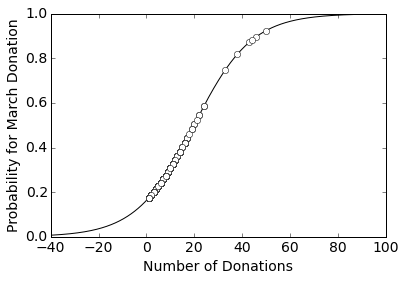

In [17]:
def logistic(b0, b1, x):
    linear = b0 + b1 * x
    return np.exp(linear) / (1.0 + np.exp(linear))

beta0, beta1 = result.params
donations = np.linspace(-40, 100, num=df.donations.count())

plt.plot(donations, logistic(beta0, beta1, donations), 'k-')
plt.plot(df.donations, logistic(beta0, beta1, df.donations), 'wo')
plt.xlabel('Number of Donations')
plt.ylabel('Probability for March Donation')

### pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal.

In [18]:
result.pred_table(threshold=0.5)

array([[ 433.,    5.],
       [ 130.,    8.]])

### We only predicted 8 of the 138 positives. This model and threshold value leads to numerous false negatives.

In [19]:
zeros, ones = df.march2007.count() - sum(df.march2007), sum(df.march2007)
print zeros, ones

438 138


### Let's further quantify the goodness of fit:

In [20]:
# taken from https://github.com/statsmodels/statsmodels/issues/1577

def precision(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0
    is the True.

    Analagous to (absence of) Type I errors. Probability that a randomly
    selected document is classified correctly. I.e., no false negatives.
    """
    tp, fp, fn, tn = map(float, pred_table.flatten())
    return tp / (tp + fp)


def recall(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0
    is the True.

    Analagous to (absence of) Type II errors. Out of all the ones that are
    true, how many did you predict as true. I.e., no false positives.
    """
    tp, fp, fn, tn = map(float, pred_table.flatten())
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return np.nan


def accuracy(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0
    is the True.
    """
    tp, fp, fn, tn = map(float, pred_table.flatten())
    return (tp + tn) / (tp + tn + fp + fn)


def fscore_measure(pred_table, b=1):
    """
    For b, 1 = equal importance. 2 = recall is twice important. .5 recall is
    half as important, etc.
    """
    r = recall(pred_table)
    p = precision(pred_table)
    try:
        return (1 + b**2) * r*p/(b**2 * p + r)
    except ZeroDivisionError:
        return np.nan

In [21]:
print precision(result.pred_table())
print recall(result.pred_table())
print accuracy(result.pred_table())
print fscore_measure(result.pred_table())

0.988584474886
0.769094138544
0.765625
0.865134865135


### The recall and accuracy are 77%.

#Logistic regression with many features:

In [22]:
import statsmodels.formula.api as smf
result = smf.logit(formula='march2007 ~ since_first + donations + since_last', data=df).fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.483168
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              march2007   No. Observations:                  576
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                            3
Date:                Tue, 15 Mar 2016   Pseudo R-squ.:                  0.1225
Time:                        12:48:50   Log-Likelihood:                -278.30
converged:                       True   LL-Null:                       -317.15
                                        LLR p-value:                 9.648e-17
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -0.5856      0.202     -2.902      0.004        -0.981    -0.190
since_first    -0.0188    

In [23]:
result.pred_table(threshold=0.5)

array([[ 425.,   13.],
       [ 123.,   15.]])

In [24]:
print precision(result.pred_table())
print recall(result.pred_table())
print accuracy(result.pred_table())
print fscore_measure(result.pred_table())

0.970319634703
0.775547445255
0.763888888889
0.862068965517


# Addition of a new feature

### The goodness of fit is very similar to the simple model. Let's try adding a new feature which is the overall rate of donations:

In [25]:
df['rate'] = pd.Series(df.donations / df.since_first, index=df.index)
df.head()

,since_last,donations,since_first,march2007,rate
0,2,50,98,1,0.510204
1,0,13,28,1,0.464286
2,1,16,35,1,0.457143
3,2,20,45,1,0.444444
4,1,24,77,0,0.311688


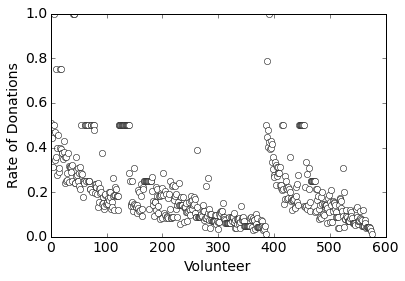

In [26]:
plt.plot(df.index, df.rate, 'wo')
plt.xlabel('Volunteer')
plt.ylabel('Rate of Donations')

### There appears to be correlation in the rate.

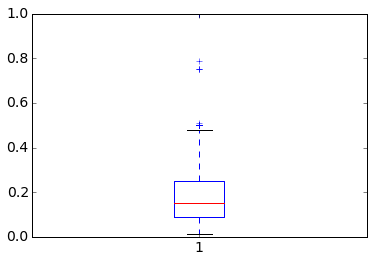

In [27]:
bp = plt.boxplot(df.rate)

### The data above appear to be correlated. Why should this be?

In [28]:
import statsmodels.formula.api as smf
result = smf.logit(formula='march2007 ~ since_last + rate', data=df).fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.501628
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              march2007   No. Observations:                  576
Model:                          Logit   Df Residuals:                      573
Method:                           MLE   Df Model:                            2
Date:                Tue, 15 Mar 2016   Pseudo R-squ.:                 0.08894
Time:                        12:48:50   Log-Likelihood:                -288.94
converged:                       True   LL-Null:                       -317.15
                                        LLR p-value:                 5.620e-13
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.7475      0.266     -2.808      0.005        -1.269    -0.226
since_last    -0.0938      0.

In [29]:
result.pred_table(threshold=0.5)

array([[ 433.,    5.],
       [ 135.,    3.]])

In [30]:
print precision(result.pred_table())
print recall(result.pred_table())
print accuracy(result.pred_table())
print fscore_measure(result.pred_table())

0.988584474886
0.762323943662
0.756944444444
0.86083499006


In [31]:
def roc_curve(r):
    thresholds = np.linspace(0.2, 0.8, num=10)
    fpr = []
    tpr = []
    for threshold in thresholds:
        tp, fp, fn, tn = map(float, r.pred_table(threshold).flatten())
        if (fp + tn > 0 and tp + fn > 0):
          fpr.append(fp / (fp + tn))
          tpr.append(tp / (tp + fn))
    return fpr, tpr

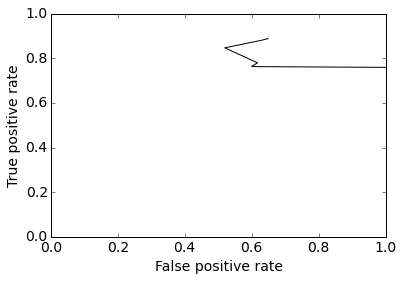

In [32]:
fpr, tpr = roc_curve(result)
plt.plot(fpr, tpr, 'k-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

### One must be mindful of the outliers which strongly influence the fit.

# Scikit-Learn Approach 

### The model is fitted to the train data. Predictions are then made using the test data:

In [33]:
from sklearn import linear_model
regr = linear_model.LogisticRegression()
columns = ['since_last', 'rate']
model = regr.fit(X=df[columns], y=df.march2007)
print type(model.coef_)
pd.DataFrame(zip(['intercept'] + columns, np.transpose(np.append(model.intercept_, model.coef_))))

<type 'numpy.ndarray'>


,0,1
0,intercept,-0.569420
1,since_last,-0.101594
2,rate,0.958572


### We note that the coefficients between the StatsModels and ScikitLearn solutions are slightly different. Probably due to the different optimization schemes used.

### Now use the test data to make predictions:

In [34]:
df_test = pd.read_csv('test_blood.csv')
df_test.drop(df_test.columns[[0, 2]], axis=1, inplace=True)
header = {u:v for u, v in zip(df_test.columns, ['since_last', 'donations', 'since_first'])}
df_test.rename(columns=header, inplace=True)

# add new column
df_test['rate'] = pd.Series(df_test.donations / df_test.since_first, index=df_test.index)
df_test.head()

,since_last,donations,since_first,rate
0,2,3000,52,57.692308
1,21,1750,38,46.052632
2,4,250,4,62.500000
3,11,2750,38,72.368421
4,4,3000,34,88.235294


In [35]:
df_test.describe()

,since_last,donations,since_first,rate
count,200.00000,200.000000,200.000000,200.000000
mean,9.49500,1483.750000,35.475000,47.489776
std,7.61907,1531.305955,25.111197,31.549327
min,0.00000,250.000000,2.000000,5.747126
25%,4.00000,500.000000,14.000000,22.727273
50%,7.00000,1000.000000,31.000000,40.697674
75%,14.00000,2000.000000,52.000000,62.500000
max,40.00000,10250.000000,98.000000,140.625000


In [36]:
y_test = regr.predict(df_test[columns])